In [3]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: Bahdanau Attention
# Author: Tracy Tao
# Date: 2022/04/19
import torch
from torch import nn
from d2l import torch as d2l

- ATTENTION: Queries(自主性）, Key（非自主性）, Value（感官输入）
    - 注意力汇聚：平均；高斯核-加权平均
    - 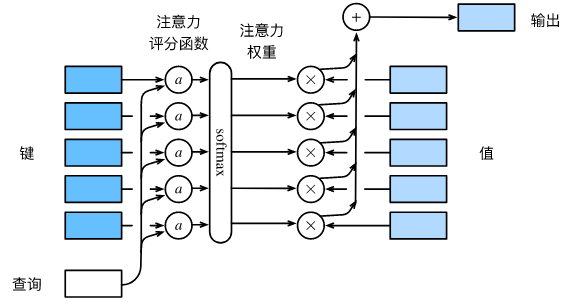
    - 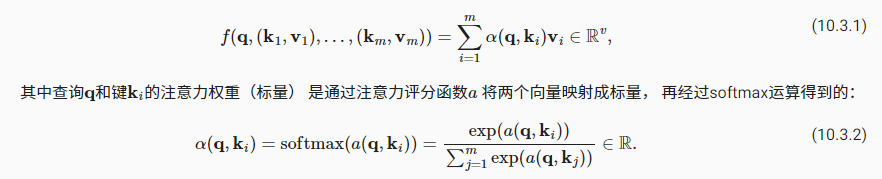
    - 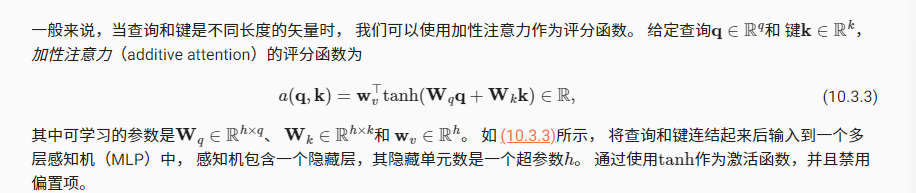
    - 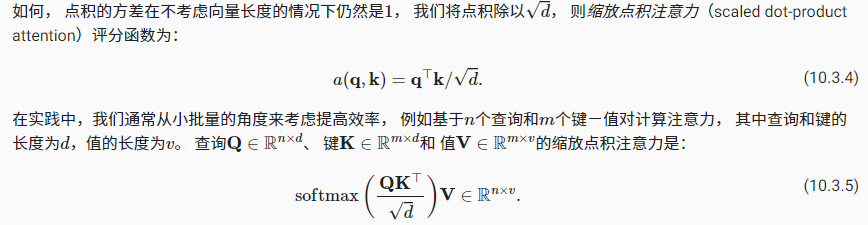

- 可微注意力模型：在预测token时，如果不是所有输入token都相关，模型将仅仅对齐（或参与）输入序列中与当前预测相关的部分。
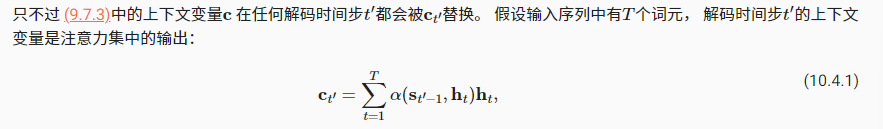
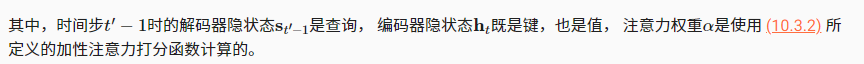
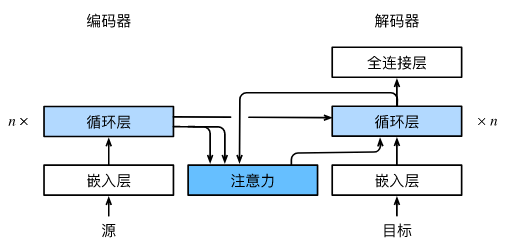

In [4]:
class AttentionDecoder(d2l.Decoder):
    '''AttentionDecoder类定义了带有注意力机制解码器的基本接口'''
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
        
    @property
    def attention_weights(self):
        raise NotImplementedError # NotImplementedError: 子类没有实现父类要求一定要实现的接口。

In [5]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    '''
    Bahdanau注意力的循环神经网络解码器
    **加性注意力评分函数**
    1. 编码器在所有时间步的最终层隐状态，将作为注意力的键和值（KV）
    2. 上一个时间步的编码器全层隐状态，将作为初始化解码器的隐状态（Q）
    3. 编码器有效长度   
    注意力的输出和输入嵌入都连结为循环神经网络解码器的输入
    '''
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs) # 继承
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout) 
        # QKV的权重维度，设置丢弃率
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 嵌入层原理:使用矩阵乘法进行降维
        self.rnn = nn.GRU(embed_size + num_hiddens, num_layers, dropout = dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size) 
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        #args表示位置参数；kwargs表示关键字参数
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1,0,2), hidden_state, enc_valid_lens)
    
    def forward(self, X , state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1,0,2)  # 输出(num_steps,batch_size,embed_size)
        outputs, self._attention_weights = [] , []
        
        for x in X:
            query = torch.unsqueeze(hidden[-1], dim=1) # unsqueeze 升维，Q:(batch_size,1,num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # C: (batch_size,1,num_hiddens)
            x = torch.cat((context, torch.unsqueeze(x, dim =1)), dim = -1) 
            # 输入x:(batch_size, 1, embed_size)
            # 输出x:(batch_size, 1, embed_size + num_hiddens)
            # 转换x:(1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1,0,2), hidden_state) 
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
         # 循环退出:outputs: (num_steps, batch_size, hidden_size)
        outputs = self.dense(torch.cat(outputs, dim = 0)) 
        # 全连接后: outputs: (num_steps, batch_size, vocab_size)
        return outputs.permute(1,0,2), [enc_ouputs, hidden_state, enc_valid_lens] 
        # enc_ouputs作为KV, hidden_size是下一时间步的Q，编码器有效长度
    @property
    def attention_weights(self):
        return self._attention_weights
        
            
    
        

In [8]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=2)
encoder.eval() # 评估模式

Seq2SeqEncoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(8, 16, num_layers=2)
)

In [9]:
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=2)
decoder.eval()

Seq2SeqAttentionDecoder(
  (attention): AdditiveAttention(
    (W_k): Linear(in_features=16, out_features=16, bias=False)
    (W_q): Linear(in_features=16, out_features=16, bias=False)
    (w_v): Linear(in_features=16, out_features=1, bias=False)
    (dropout): Dropout(p=0, inplace=False)
  )
  (embedding): Embedding(10, 8)
  (rnn): GRU(24, 2)
  (dense): Linear(in_features=16, out_features=10, bias=True)
)

In [13]:
net = d2l.EncoderDecoder(encoder, decoder)
net # 生成模型

EncoderDecoder(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(10, 8)
    (rnn): GRU(8, 16, num_layers=2)
  )
  (decoder): Seq2SeqAttentionDecoder(
    (attention): AdditiveAttention(
      (W_k): Linear(in_features=16, out_features=16, bias=False)
      (W_q): Linear(in_features=16, out_features=16, bias=False)
      (w_v): Linear(in_features=16, out_features=1, bias=False)
      (dropout): Dropout(p=0, inplace=False)
    )
    (embedding): Embedding(10, 8)
    (rnn): GRU(24, 2)
    (dense): Linear(in_features=16, out_features=10, bias=True)
  )
)